## Exploratory Data Analysis 

- **Data**: The data used in the EDA was the 2021A subset of the NA62 dataset from CERN'S Super Proton Synchrotron. 
- **Purpose**: The purpose of this notebook is to conduct an exploratory data analysis on the 2021A data.
- **Reference**: The helper functions and part of the EDA code are referenced from TRIUMF Capstone Project 2022 EDA (https://github.com/TRIUMF-Capstone2022/richai/blob/main/notebooks/EDA.ipynb)

**Notes**
- Labels are 0: Muon, 1: Pion, 2: Positron

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob
import warnings

In [2]:
with h5py.File('../../data/bvelghe/capstone2023/CaloRICH_Run11100_CTRL_v1.h5', 'r') as f:
    datasets = list(f.keys())
    print("Datasets in the file:", datasets)


Datasets in the file: ['Events', 'HitMapping', 'Hits']


In [3]:
with h5py.File('../../data/bvelghe/capstone2023/CaloRICH_Run11100_CTRL_v1.h5', 'r') as f:

    print((f['Hits'].dtype))

[('assigned_flag', '<i4'), ('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')]


## 1. Helper functions 

### Read in HDF5 data 

In [20]:
def read_RICHAI_data(file_paths):
    """Read in all the RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    

    
    data_files = {}
    for file_path in file_paths:
        
        if file_paths[0].split("/")[1]=="fast_scratch_1":
            name = file_path.split("/")[4].split(".")[0] + "/" + file_path.split("/")[4].split(".")[1]

        else:
            name = file_path.split("/")[3] + "/" + file_path.split("/")[4].split(".")[0]
                    
#             patch_check=file_path.split("/")[4].split(".")[2]
        
#             if len(patch_check.split("_")) == 2: 
#                     name=name + '_' + patch_check.split('_')[1]   
        
        data_files[name] = h5py.File(file_path)
    
    return data_files

### Convert HDF5 events data to Pandas dataframe

In [21]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["track_pos_x"] = dfile["Events"]["track_pos"][:, 0]
    df["track_pos_y"] = dfile["Events"]["track_pos"][:, 1]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df

### Add string labels to particles 

In [22]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)
    
    Parameters
    ----------
    label : int
        Integer specifying class the class of the particle
    
    """
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

### Correct alignment of x and y hit positions 

In [23]:
def realign_x_hits(x, mirror):
    """translate X coordinates with fix
    
    Parameters
    ----------
    x : float
        X-coordiante of hit.
    mirror : int
        Integer indicating mirror which photon hit. 

    """
    if mirror == 0:
        return x - 146.8
    else:
        return x - 196.7
    
def realign_y_hits(y, mirror):
    """translate Y coordinates with fix
    
    Parameters
    ----------
    y : float
        X-coordiante of hit.
    mirror : int
        Integer indicating mirror which photon hit. 

    """
    if mirror == 0:
        return y - 19.8
    else:
        return y - 9.5

### Sample a subset for each particle class 

In [24]:
def get_class_samples(df, n, seed, momentum_bin=None, wide=None):
    """Sample n samples for each particle class from the events dataframe
    Parameters
    ----------
    df : dataframe
        A pandas DataFrame representation of the HDF5 Events file.
        
    n : int
        The number of samples required.
    
    seed : int
        RNG seed number. 
    
    momentum_bin : boolean
        Indicate whehter to sample using momentum bins.
    
    wide = boolean
        Indicate whehter to use wide or narrow bins.
        
    Returns
    -------
    samples : pd.DataFrame
        Dataframe containing randomly sampled events.
    
    """
    
    if momentum_bin and wide:
        df = df.query("wide_momentum_bin == @momentum_bin")
        
    if momentum_bin and not wide:
        df = df.query("narrow_momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
           # df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples

### Sample the same number of examples from each class to make a balanced dataset (to be tested later)

In [25]:
def undersample(df):
    """Undersample majority class to match number of minority class
    Parameters
    ----------
    df : pd.dataframe
        A pandas DataFrame representation of the HDF5 Events file.
        
    Returns
    -------
    final_df : pd.DataFrame
        Dataframe containing equal class sizes.
    
    """
    classes = df.label.value_counts().to_dict()
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

### Sample the same number of data from each momentum bin, with a bin size of 1 Gev

In [26]:
def uniform_sampling(data):
    """
    Randomly samples the same number of examples in each bin of track_momentum with bin size = 1 Gev, 
    the number of examples is equal to the minimum number of examples in all the bins 
    """

    np.random.seed(42)
    data = data.query('track_momentum >= 20 & track_momentum <= 45 & `class`=="muon"')

    bins = np.arange(20, 46, 1)
    data['momentum_bin'] = pd.cut(data['track_momentum'], bins=bins)


    bin_counts = data.groupby(['momentum_bin']).size()
    min_counts = bin_counts.min()

    sampled_df = data.groupby('momentum_bin').apply(lambda x: x.sample(n=min_counts))
    sampled_df = sampled_df.reset_index(drop=True)
    


    return sampled_df


### Calculate the time difference between CHOD time and hits for each event

In [27]:
def delta(
    dset_unbalanced, 
    df_balanced, 
    delta = 0.3
):
    """Compute the mean difference between CHOD time and photon hits for each event after filtering
    
    Parameters
    ----------
    dset_unbalanced : HDF5
        Original HDF5 Events file.
    
    dset_unbalanced : HDF5
        Synthetic data HDF5 Events file.
    
    delta : float
        The cut-off value for filtering the difference between CHOD time and photon hit time
        
    Returns
    -------
    df_balanced_copy : pd.DataFrame
        Dataframe containing additional column with number of hits and mean_delta after filtering.
    
    """
    
    # Event indices in balanced dataset
    event_nums = df_balanced['original_index']

    # Defining total_hits_filtered
    hits_filtered_perevent = pd.Series(np.zeros(df_balanced.shape[0], dtype='int32'), index=event_nums,dtype='int32')
    delta_perevent = pd.Series(np.zeros(df_balanced.shape[0], dtype='int32'), index=event_nums,dtype='int32')

    for event_idx in event_nums:
        # Finding the number of hits for each event in the hit_array from hit_mapping
        idx_from = dset_unbalanced.hit_mapping[event_idx]
        idx_to = dset_unbalanced.hit_mapping[event_idx+1]
        hit_times = dset_unbalanced.hit_array['hit_time'][idx_from:idx_to]

        # Extracting delta for each event
        delta_time = dset_unbalanced.event_array[event_idx]["chod_time"] - hit_times
        # Fetching the count of hit_times in the range hit_time +- delta_tolerance
        hits_filtered_perevent[event_idx] = delta_time[np.abs(delta_time) > delta].shape[0]
        delta_perevent[event_idx] = np.mean(delta_time[np.abs(delta_time) < delta])

    # updating df_balanced for total hits
    df_balanced_copy = df_balanced
    df_balanced_copy['hits_filtered_per_event'] = hits_filtered_perevent
    df_balanced_copy['mean_delta'] = delta_perevent
    
    return df_balanced_copy

### Get hit data 

In [28]:
def get_hit_info_df(f, df, event):
    """Get the hit info for an event in a pandas dataframe
    
    Parameters
    ----------
    f : HDF5 file
        The RICHAI HDF5 file.
    df : pandas DataFrame
        A pandas DataFrame representation of the HDF5 Events file.
    event : int
        The event number to get the hit info for.
        
    Returns
    -------
    positions : pd.DataFrame
        pandas DataFrame with hits data for a given event
    """
    positions = []
    
    # get our hit data for this event
    idx_from = df.loc[event]["first_hit"]
    idx_to = df.loc[event]["last_hit"]
    hit_data = f["Hits"][idx_from:idx_to]
    
    # get our pm locations for this event
    for hit in hit_data:
        assigned_flag, disk_id, pm_id, sc_id, up_dw_id, hit_time = hit
        pm_idx = compute_seq_id(disk_id,up_dw_id,sc_id,0,pm_id)
        
        positions.append(position_map[pm_idx])
    
    # add hit time, chod time, and delta
    positions = pd.DataFrame(positions, columns=["x", "y", "mirror"])
    positions["x_realigned"] = positions.apply(lambda a: realign_x_hits(a.x, a.mirror), axis=1) 
    positions["y_realigned"] = positions.apply(lambda a: realign_y_hits(a.y, a.mirror), axis=1) 
    positions["hit_time"] = hit_data["hit_time"]
    positions["chod_time"] = df["chod_time"][event]
    positions["chod_delta"] = positions["hit_time"] - positions["chod_time"]
    positions["class"] = df["class"][event]
    positions["event"] = event
    positions['momentum'] = df['track_momentum'][event]
    positions['ring_radius'] = df['ring_radius'][event]
    positions['ring_radius_calc'] = df['ring_radius_cal'][event]
    positions['ring_centre_pos_x'] = df['ring_centre_pos_x'][event]
    positions['ring_centre_pos_y'] = df['ring_centre_pos_y'][event]
    
    return positions

### Compute the seq_id of RICH PMT sequence ID 

In [29]:
def compute_seq_id(disk_id,up_dw_id,sc_id,or_id,pm_id):
    """Compute the RICH PMT sequence ID"""
    # We are not checking for shape here ... let it crash if need be
    seq_id = np.empty(disk_id.shape,dtype=int)
    seq_id[or_id < 1] = sc_id[or_id < 1] * 8 + pm_id[or_id < 1] + \
        up_dw_id[or_id < 1] * 61 * 8 + disk_id[or_id < 1] * 61 * 8 * 2
    seq_id[or_id >= 1] = 61 * 8 * 2 * 2 + sc_id[or_id >= 1] + \
        up_dw_id[or_id >= 1] * 61 + disk_id[or_id >= 1] * 61 * 2
    return seq_id

### Calculate the ring radius based on mass and momentum

In [30]:
def calc_ring_radius(m,p):
    """
        Returns the expected ring radius [m]
        m : mass of the particle in MeV/c^2
        p : track momentum in MeV/c
    """
    F_M = 17.0 # Focal length [m]
    N = 1 + 62.8e-6 # Neon refractive index
    r = F_M*N*p*np.sqrt(1 - (m**2 + p**2)/(N**2*p**2))/np.sqrt(m**2 + p**2)
    return r

## 2. EDA on the events data

### Read in the 2021A dataset 

In [31]:
file_paths = glob.glob("../data/bvelghe/capstone2023/*")
data_files = read_RICHAI_data(file_paths)
data_files.keys()

dict_keys(['capstone2023/CaloRICH_Run11100_CTRL_v1'])

In [32]:
f = data_files['capstone2023/CaloRICH_Run11100_CTRL_v1']
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [33]:
df = events_to_pandas(f)

In [34]:
df.head(5)

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,track_pos_x,track_pos_y,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,first_hit,last_hit,total_hits
0,11100,1468,11235,0,22.761024,7.789327,-195.126602,-153.930786,172.410950,-190.112167,-154.579514,2.083958e-12,1.0,1.914225e-24,0,0,20,20
1,11100,1468,11812,0,23.600529,0.000198,-316.197571,-57.275291,175.251694,-309.305939,-54.844410,7.732010e-10,1.0,8.275686e-19,0,20,39,19
2,11100,1468,14104,0,16.275131,11.789481,-88.681786,58.657421,155.040802,-88.665840,59.053833,1.216099e-37,1.0,1.216099e-37,0,39,65,26
3,11100,1468,14634,1,36.436443,7.426493,-39.124882,81.853058,185.832642,-35.864372,80.708580,8.006046e-03,1.0,3.626212e-02,0,65,117,52
4,11100,1468,18030,0,16.525362,8.923427,-66.697784,-15.932317,158.641846,-65.450981,-20.469883,1.216099e-37,1.0,1.216099e-37,0,117,141,24


In [35]:
df.tail()

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,track_pos_x,track_pos_y,ring_radius,ring_centre_pos_x,ring_centre_pos_y,ring_likelihood_pion,ring_likelihood_muon,ring_likelihood_positron,label,first_hit,last_hit,total_hits
2404684,11100,1,2552956,1,38.319115,6.629536,-155.661331,11.593651,189.915161,-158.066360,12.588452,1.902452e-09,1.834121e-02,1.0,2,100912331,100912382,51
2404685,11100,1,2561786,0,23.008614,10.341508,-106.115143,-65.577164,191.652313,-104.966537,-63.518814,1.033193e-12,7.798473e-11,1.0,2,100912382,100912455,73
2404686,11100,1,2633497,0,22.232542,3.112587,-319.103729,-4.378553,188.885483,-314.060120,-0.492267,1.216099e-37,9.949649e-30,1.0,2,100912455,100912494,39
2404687,11100,1,2672987,0,21.753626,18.915501,-228.668686,-109.272804,192.003479,-231.127029,-112.405830,1.216099e-37,1.216099e-37,1.0,2,100912494,100912540,46
2404688,11100,1,2736614,0,31.200739,7.573225,-98.804474,-34.762177,192.807083,-98.114532,-34.978989,8.727528e-26,1.253717e-08,1.0,2,100912540,100912568,28


### Add string labels to particles 

In [36]:
# add class label (text)

df["class"] = df["label"].apply(get_string_label)

In [37]:
df = df.query('`class` != "positron"')

In [38]:
plt.style.use('tableau-colorblind10')
plt.rcParams["patch.force_edgecolor"] = True

# line styles for positron, pion, muon
lss = ['dashed', 'dashdot', "dotted"]

### Compute the calculated ring radius 

In [39]:
# add new column with the corresponding mass value for pion and muon
# refer to calc_ring_radius() function provided in TRIUMF repo for details
# mass of the particle in MeV/c^2
df['mass'] = [105.66 if x == 0 else 139.57 for x in df['label']]

In [40]:
# add new column with the calculated ring radius from the theoretical formula
# ring_radius_cal in mm (consistent with ring_radius in the event dataset)
# in below code, the first 1000 is to convert track_momentum from GeV/c to MeV/c
# the second 1000 is to convert ring_radius_cal from m to mm
df['ring_radius_cal'] = calc_ring_radius(df['mass'], df['track_momentum']*1000)*1000

/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 2.1. Plotting track momentum distributions for each particle

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/539279712.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[1].set_xticklabels(g.figure.axes[1].get_xticklabels(),
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/539279712.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(),
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/539279712.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[1].set_yticklabels(g.figure.axes[1].get_yticklabels(),


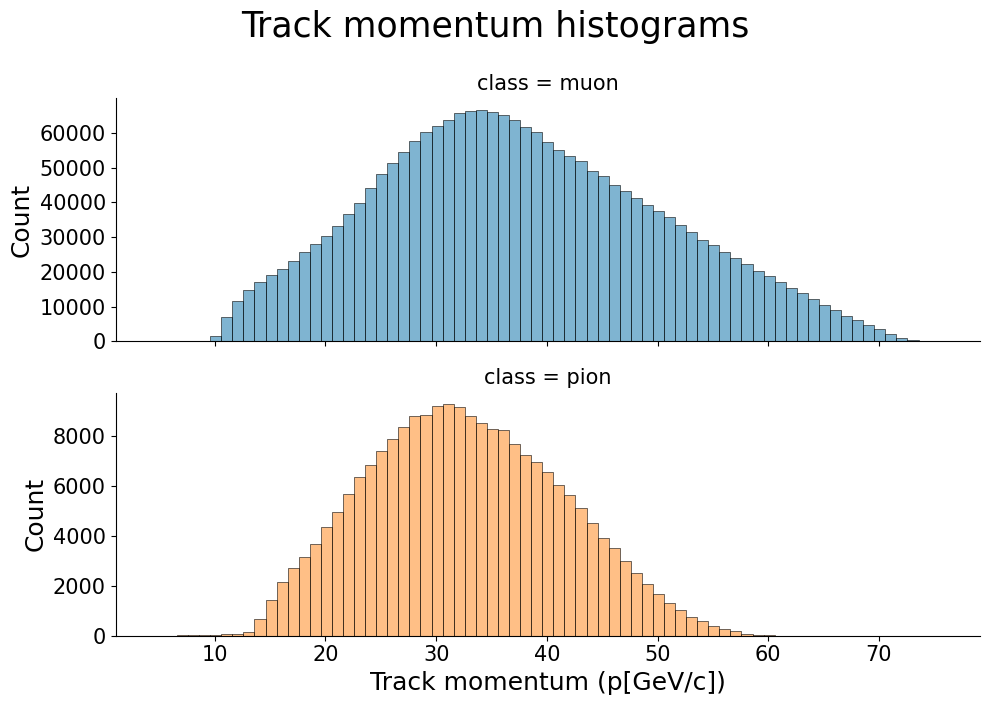

In [41]:
g = sns.displot(
    data=df,
    x="track_momentum",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Track momentum histograms", y=1, fontsize=25)
g.set_titles(size=15)
g.set_xlabels("Track momentum (p[GeV/c])", fontsize=18)
g.set_ylabels(fontsize=18)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.figure.axes[1].set_xticklabels(g.figure.axes[1].get_xticklabels(), 
                                fontdict={'fontsize': 15})
g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(), 
                                fontdict={'fontsize': 15})
g.figure.axes[1].set_yticklabels(g.figure.axes[1].get_yticklabels(), 
                                fontdict={'fontsize': 15})

g.tight_layout()

### 2.2 Total number of hits per event 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


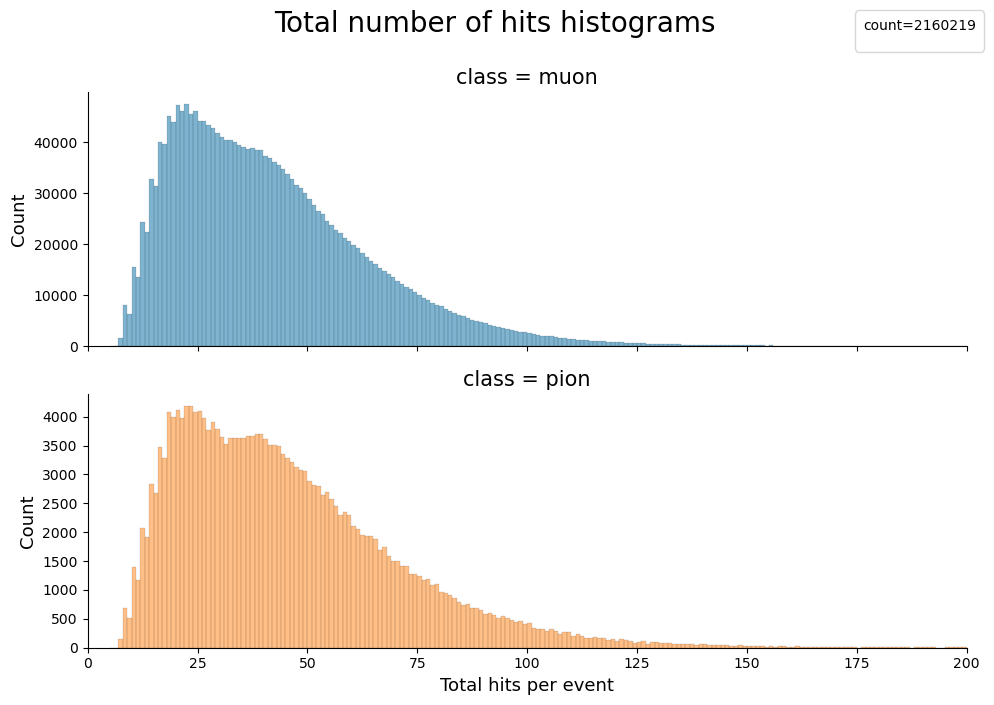

In [42]:

g = sns.displot(
    data=df,
    x="total_hits",
    col="class",
    hue="class",
    binwidth=1,
    facet_kws=dict(sharey=False),
    col_wrap=1,
    legend=False
)

g.fig.suptitle("Total number of hits histograms", y=1, fontsize=20)
g.set_titles(size=15)
g.set_xlabels("Total hits per event", fontsize=13)
g.set_ylabels(fontsize=13)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.fig.legend(title=f"count={df.label.value_counts()[0]}", 
                fontsize=15)

for ax in g.axes:
    ax.set_xlim(0, 200)
    
plt.tight_layout()
plt.show()

### Sample the same number of data per momentum bin 

In [43]:
sampled_data = uniform_sampling(df)

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/3789954010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['momentum_bin'] = pd.cut(data['track_momentum'], bins=bins)


### 2.3 Plot the distribution of the uniformly sampled data

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/1427692033.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(),


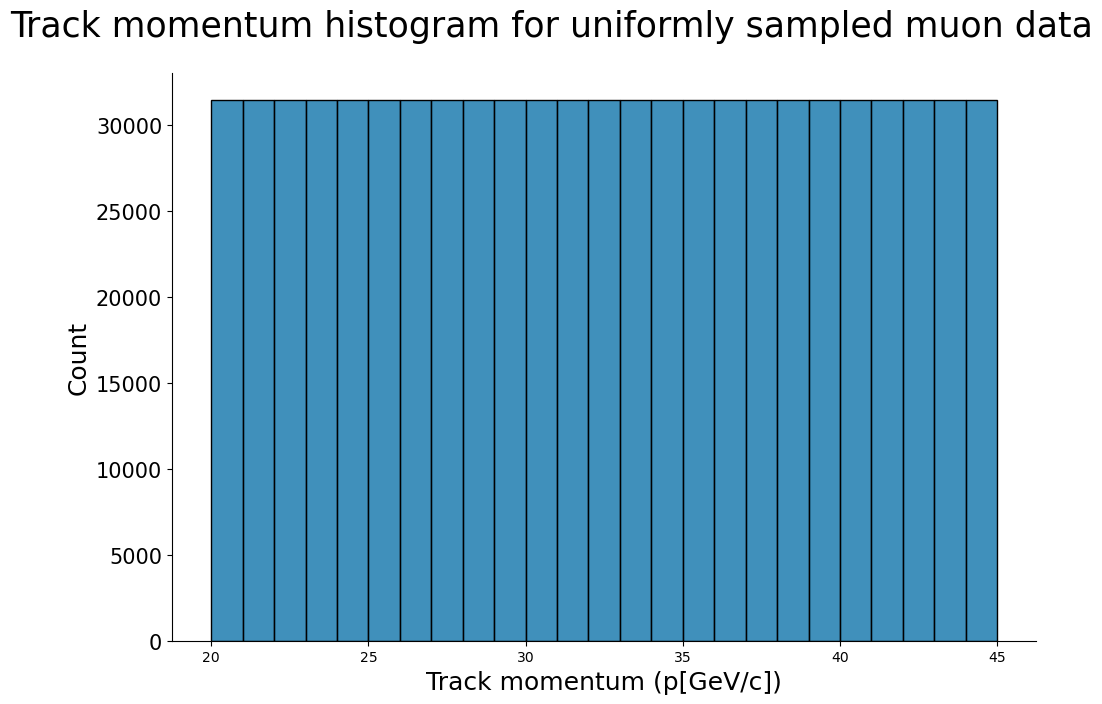

In [46]:
g = sns.displot(
    data=sampled_data,
    x="track_momentum",
    binwidth=1
)

g.fig.suptitle("Track momentum histogram for uniformly sampled muon data", y=1, fontsize=25)
g.set_titles(size=15)
g.set_xlabels("Track momentum (p[GeV/c])", fontsize=18)
g.set_ylabels(fontsize=18)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(), 
                                fontdict={'fontsize': 15})


g.tight_layout()

### 2.4 2D histograms showing track position distributions for each particle

Text(0.5, 1, '2D Histogram Showing Positional Distribution of Muons')

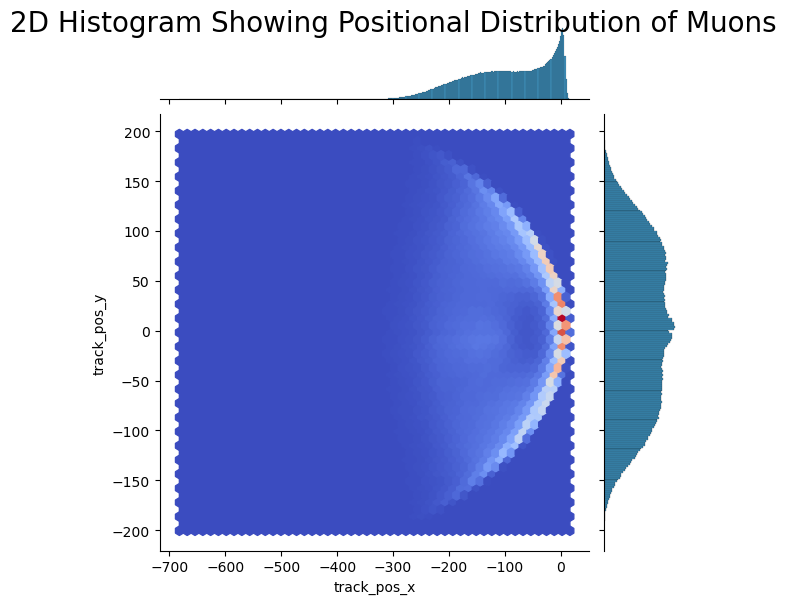

In [47]:
df_muon = df.query('`class` == "muon"')
g = sns.jointplot(data=df_muon, x='track_pos_x', y='track_pos_y', kind='hex', cmap='coolwarm')
g.fig.suptitle("2D Histogram Showing Positional Distribution of Muons", y=1, fontsize=20)

Text(0.5, 1, '2D Histogram Showing Positional Distribution of Pions')

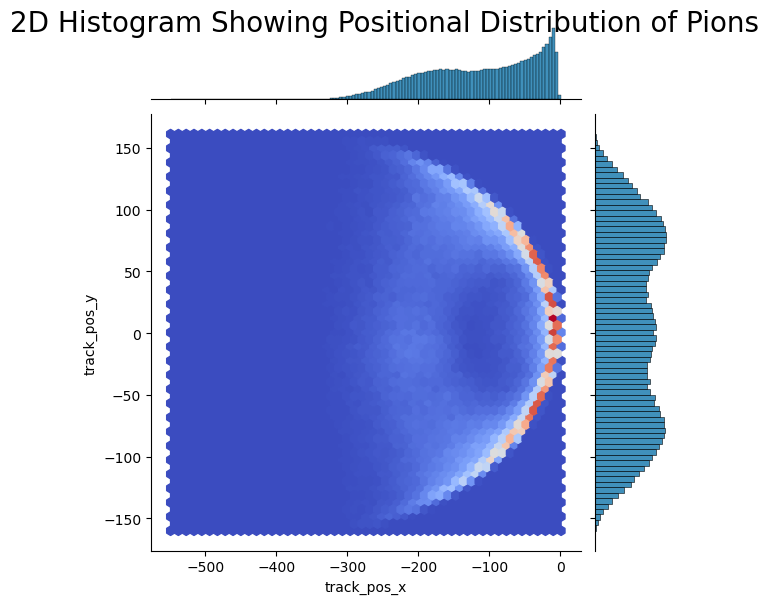

In [48]:
df_muon = df.query('`class` == "pion"')
g = sns.jointplot(data=df_muon, x='track_pos_x', y='track_pos_y', kind='hex', cmap='coolwarm')
g.fig.suptitle("2D Histogram Showing Positional Distribution of Pions", y=1, fontsize=20)

### 2.6 Ring radius vs. track momentum 

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/2226004112.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(),
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/2226004112.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(),


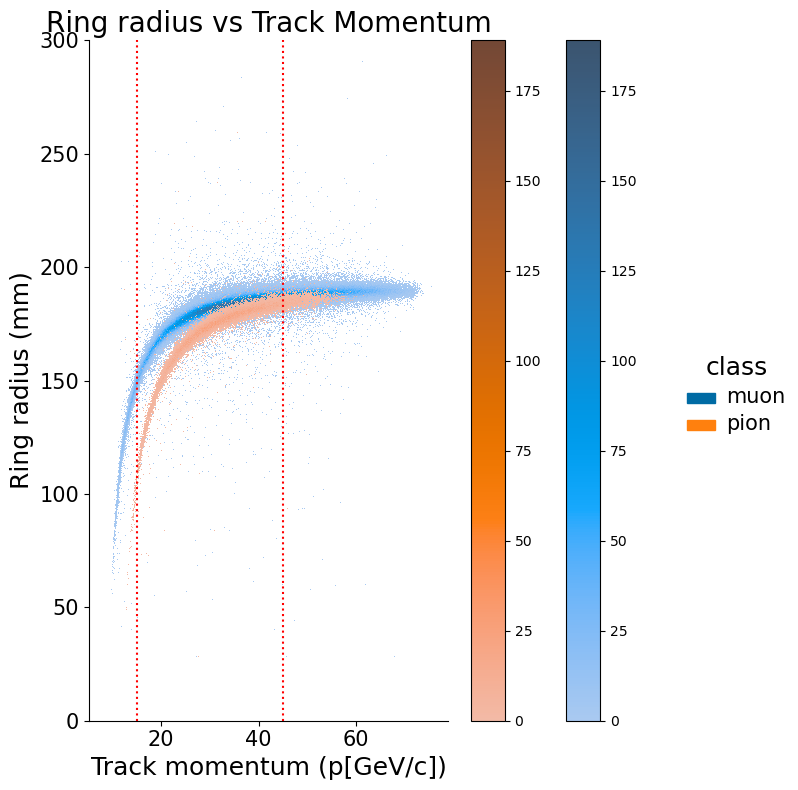

In [49]:
df_subset = df.query(("abs(ring_centre_pos_y) < 500 & abs(ring_centre_pos_x) < 500"))

g = sns.displot(
    x=df_subset["track_momentum"],
    y=df_subset["ring_radius"],
    hue=df_subset["class"],
    cbar=True, 
    binwidth=(0.1, 0.1)
);

g.ax.set_title("Ring radius vs Track Momentum", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=18)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 15)
g.ax.tick_params(axis='y', labelsize= 15)
g.ax.set_ylim([0, 300])    # some noise above 300 makes the plot ugly
g.fig.set_figheight(8)
g.fig.set_figwidth(8)
g.tight_layout()

g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), 
                                fontdict={'fontsize': 15})
g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(), 
                                fontdict={'fontsize': 15})
g.legend.get_title().set_fontsize(18)

for text in g.legend.texts:
    text.set_fontsize(15)
    
g.figure.axes[0].set_rasterized(rasterized=True)

plt.axvline(15, color="red", linestyle="dotted")
plt.axvline(45, color="red", linestyle="dotted")

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/3347123557.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(),
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/3347123557.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(),


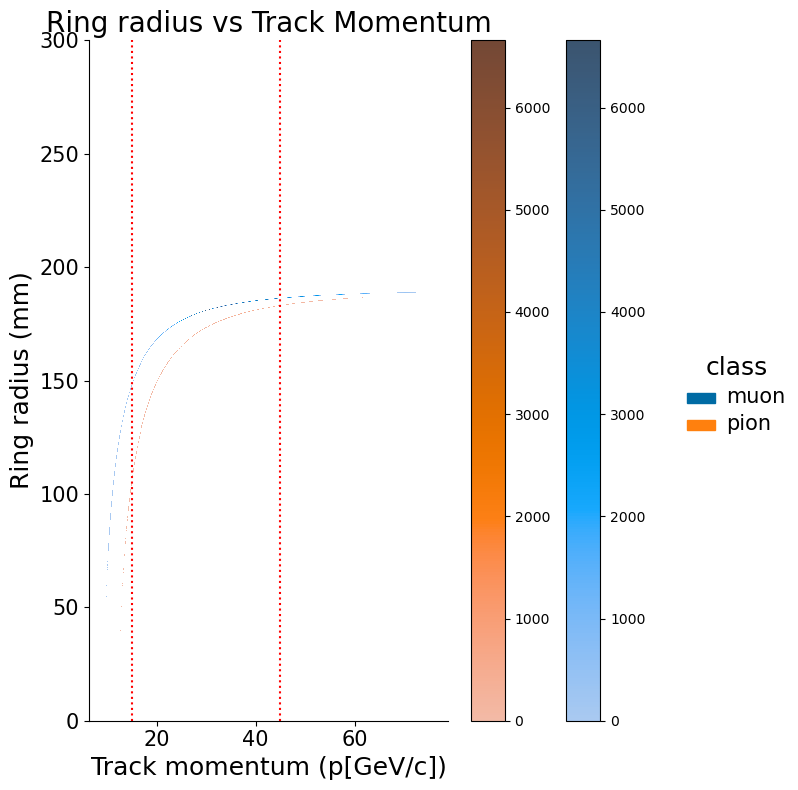

In [50]:
g = sns.displot(
    x=df_subset["track_momentum"],
    y=df_subset["ring_radius_cal"],
    hue=df_subset["class"],
    cbar=True, 
    binwidth=(0.1, 0.1)
);

g.ax.set_title("Ring radius vs Track Momentum", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=18)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 15)
g.ax.tick_params(axis='y', labelsize= 15)
g.ax.set_ylim([0, 300])    # some noise above 300 makes the plot ugly
g.fig.set_figheight(8)
g.fig.set_figwidth(8)
g.tight_layout()

g.figure.axes[0].set_xticklabels(g.figure.axes[0].get_xticklabels(), 
                                fontdict={'fontsize': 15})
g.figure.axes[0].set_yticklabels(g.figure.axes[0].get_yticklabels(), 
                                fontdict={'fontsize': 15})
g.legend.get_title().set_fontsize(18)

for text in g.legend.texts:
    text.set_fontsize(15)
    
g.figure.axes[0].set_rasterized(rasterized=True)

plt.axvline(15, color="red", linestyle="dotted")
plt.axvline(45, color="red", linestyle="dotted")

### 2.7 Distribution of number of hits binned by calculated radius 

In [51]:
df['ring_radius_cal'].max()

189.08502874317813

In [52]:
bin_labels = pd.cut(df['ring_radius_cal'], bins=range(0, 201, 10))

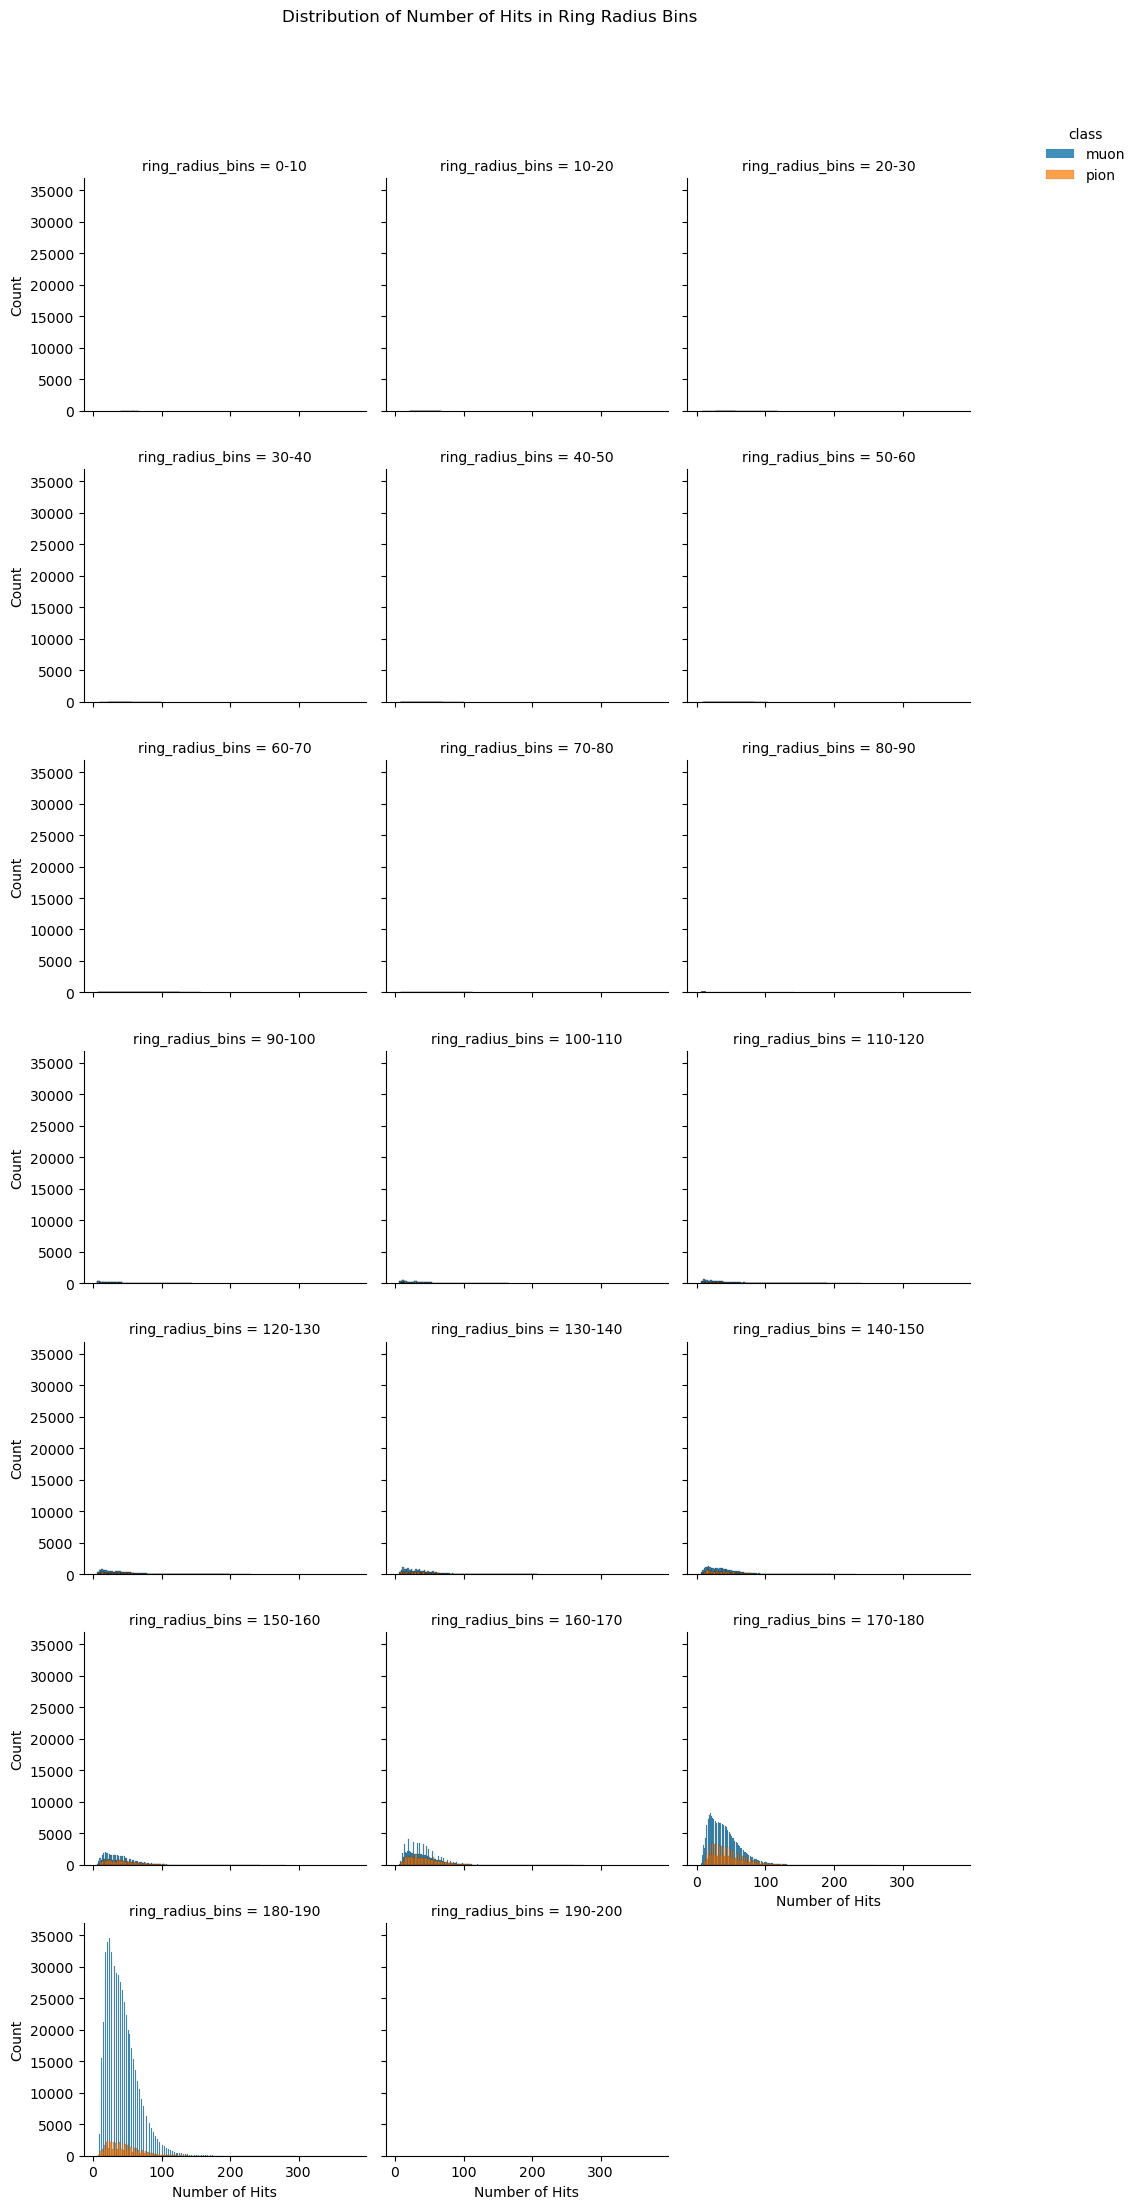

In [53]:
bins = range(0, 201, 10)
labels = [f'{i}-{i+10}' for i in range(0, 191, 10)]
df['ring_radius_bins'] = pd.cut(df['ring_radius_cal'], bins=bins, labels=labels)

g = sns.FacetGrid(df, col='ring_radius_bins', hue='class', col_wrap=3)
g.map(sns.histplot, 'total_hits')

g.set_axis_labels('Number of Hits', 'Count')
g.fig.suptitle('Distribution of Number of Hits in Ring Radius Bins', y=1.05)
g.add_legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Read in the RICH pmt position data

In [54]:
position_map = np.load('../data/rich_pmt_positions.npy')
position_map.shape

(1952, 3)

In [55]:
sampled_data = uniform_sampling(df)

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_68258/3789954010.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['momentum_bin'] = pd.cut(data['track_momentum'], bins=bins)


In [66]:
sampled_data.to_csv('../data/sampled_data.csv')

In [142]:
# hit_data = [get_hit_info_df(f, sampled_data, index) for index in sampled_data.index]

# hit_data_df = pd.concat(hit_data, axis=0, ignore_index=True)
    


In [143]:
# hit_data_df.to_csv('../data/hit_data_uniform.csv')

In [56]:
hit_data_df = pd.read_csv("../data/hit_data_uniform.csv")

In [57]:
hit_data_df

,Unnamed: 0,x,y,mirror,x_realigned,y_realigned,hit_time,chod_time,chod_delta,class,event,momentum,ring_radius,ring_radius_calc,ring_centre_pos_x,ring_centre_pos_y
0,0,-36.0,77.94,0.0,-182.8,58.140002,53.321484,19.203901,34.117584,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
1,1,-45.0,62.35,0.0,-191.8,42.549998,53.034840,19.203901,33.830940,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
2,2,108.0,140.30,0.0,-38.8,120.500003,53.126720,19.203901,33.922820,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
3,3,234.0,109.12,0.0,87.2,89.320003,52.964043,19.203901,33.760140,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
4,4,207.0,124.71,0.0,60.2,104.909999,54.722860,19.203901,35.518960,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32858061,32858061,45.0,187.06,0.0,-101.8,167.259998,69.233450,22.204435,47.029015,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858062,32858062,-72.0,77.94,0.0,-218.8,58.140002,69.579810,22.204435,47.375374,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858063,32858063,0.0,202.65,0.0,-146.8,182.849994,69.763150,22.204435,47.558716,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858064,32858064,-9.0,155.88,0.0,-155.8,136.080005,69.371130,22.204435,47.166695,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938


In [146]:
sampled_data.columns

Index(['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum',
       'chod_time', 'track_pos_x', 'track_pos_y', 'ring_radius',
       'ring_centre_pos_x', 'ring_centre_pos_y', 'ring_likelihood_pion',
       'ring_likelihood_muon', 'ring_likelihood_positron', 'label',
       'first_hit', 'last_hit', 'total_hits', 'class', 'wide_momentum_bin',
       'narrow_momentum_bin', 'mass', 'ring_radius_cal', 'bin_labels',
       'bin_labels_sorted', 'ring_radius_bins', 'momentum_bin'],
      dtype='object')

In [58]:
# merged_df = sampled_data.merge(hit_data_df, left_index=True, right_on='event')

### Filter for in-time hits only

In [59]:
hit_data_df_intime = hit_data_df.query('abs(chod_delta) <= 0.5')

### Filter out outliers in hit positions 

In [63]:
hit_data_df_intime = hit_data_df_intime.query('abs(x_realigned) <= 1000 & abs(y_realigned) <= 1000')

In [64]:
hit_data_df_intime

,Unnamed: 0,x,y,mirror,x_realigned,y_realigned,hit_time,chod_time,chod_delta,class,event,momentum,ring_radius,ring_radius_calc,ring_centre_pos_x,ring_centre_pos_y
10,10,90.0,-265.00,1.0,-106.7,-274.500000,19.097347,19.203901,-0.106554,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
11,11,99.0,-62.35,1.0,-97.7,-71.849998,19.480330,19.203901,0.276428,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
12,12,90.0,-46.77,1.0,-106.7,-56.270000,19.465616,19.203901,0.261715,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
13,13,99.0,-249.42,1.0,-97.7,-258.919998,18.959799,19.203901,-0.244102,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
14,14,126.0,-171.47,1.0,-70.7,-180.970001,19.260246,19.203901,0.056345,muon,0,20.456100,169.37271,169.115423,-238.677630,-163.01723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32858050,32858050,243.0,-31.18,1.0,46.3,-40.680000,22.350718,22.204435,0.146282,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858051,32858051,9.0,249.42,1.0,-187.7,239.919998,22.678827,22.204435,0.474392,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858052,32858052,-45.0,218.24,1.0,-241.7,208.740005,21.900766,22.204435,-0.303669,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938
32858053,32858053,-99.0,187.06,1.0,-295.7,177.559998,22.063538,22.204435,-0.140898,muon,785924,44.718437,187.09007,186.276100,-95.501495,84.69938


In [65]:
sampled_data

,run_id,burst_id,event_id,track_id,track_momentum,chod_time,track_pos_x,track_pos_y,ring_radius,ring_centre_pos_x,...,ring_likelihood_positron,label,first_hit,last_hit,total_hits,class,mass,ring_radius_cal,ring_radius_bins,momentum_bin
0,11100,1403,770357,0,20.456100,19.203901,-242.684845,-160.146179,169.372711,-238.677628,...,6.759104e-30,0,3190409,3190451,42,muon,105.66,169.115423,160-170,"(20, 21]"
1,11100,1357,785035,0,20.563030,2.351892,-181.760086,163.970596,173.669495,-181.111511,...,1.227929e-16,0,5904765,5904792,27,muon,105.66,169.337429,160-170,"(20, 21]"
2,11100,124,2609991,0,20.993650,24.566246,-56.545204,76.687462,168.917709,-56.966621,...,2.799638e-32,0,80597298,80597363,65,muon,105.66,170.295798,170-180,"(20, 21]"
3,11100,889,1230745,0,20.068357,5.486784,-83.175415,100.606483,169.107208,-80.256264,...,4.630325e-34,0,31239517,31239568,51,muon,105.66,168.202808,160-170,"(20, 21]"
4,11100,580,2211621,0,20.880802,4.468906,-158.704697,153.221634,169.088089,-158.903854,...,2.150813e-32,0,51388069,51388131,62,muon,105.66,170.035186,170-180,"(20, 21]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785920,11100,1030,1634065,0,44.834846,25.305099,-170.799088,0.128751,182.949692,-169.082535,...,2.616825e-06,0,21488060,21488097,37,muon,105.66,186.287038,180-190,"(44, 45]"
785921,11100,339,1374514,0,44.213005,2.111290,3.663683,17.328890,185.596817,2.442378,...,1.405231e-01,0,66697757,66697776,19,muon,105.66,186.182741,180-190,"(44, 45]"
785922,11100,1250,1759731,0,44.008110,11.669228,-165.552856,-43.044388,188.047180,-165.300156,...,6.651457e-02,0,11792817,11792840,23,muon,105.66,186.128281,180-190,"(44, 45]"
785923,11100,427,1938557,0,44.981186,17.341835,-6.006274,-46.084888,186.732468,-10.232764,...,6.847338e-02,0,60910765,60910808,43,muon,105.66,186.319897,180-190,"(44, 45]"


### 2.7 2D Histogram showing distribution of hit positions for both particles 

Text(0.5, 1, 'Hit Position Distribution of Muons')

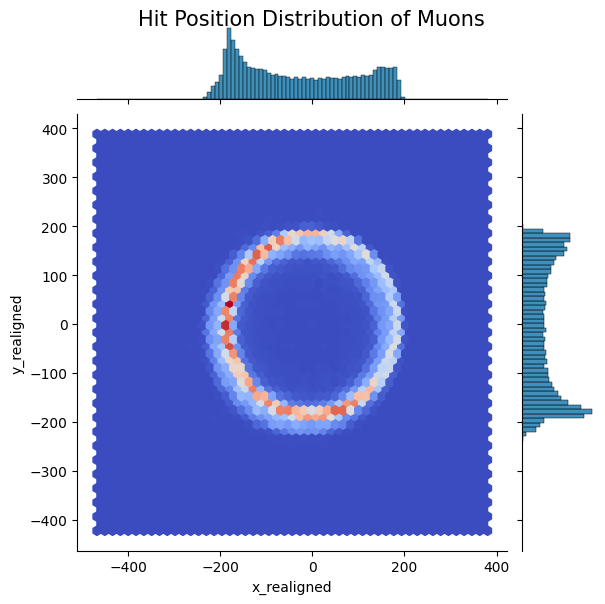

In [36]:
g = sns.jointplot(data=hit_data_df_intime.query('`class`=="muon"'), x='x_realigned', y='y_realigned', kind='hex', cmap='coolwarm')
g.fig.suptitle("Hit Position Distribution of Muons", y=1, fontsize=15)

Text(0.5, 1, 'Hit Position Distribution of Pions')

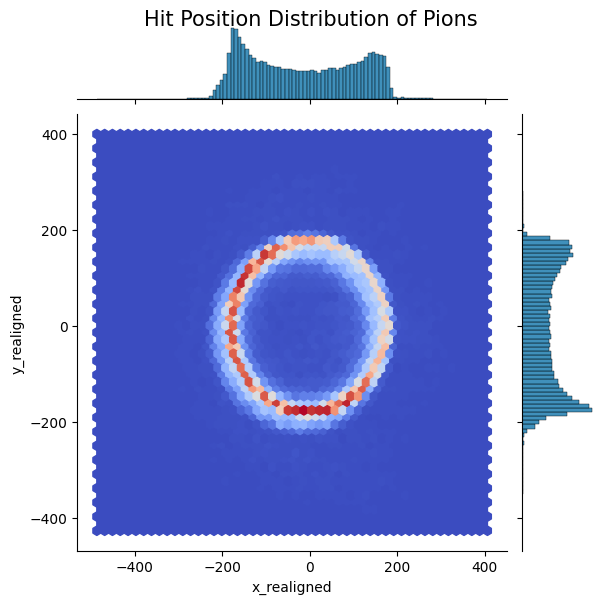

In [37]:
g = sns.jointplot(data=hit_data_df_intime.query('`class`=="pion"'), x='x_realigned', y='y_realigned', kind='hex', cmap='coolwarm')
g.fig.suptitle("Hit Position Distribution of Pions", y=1, fontsize=15)

### 2.8 Append hit data to the uniformly sampled events data 

In [44]:
# hit_data_uniform = [get_hit_info_df(f, sampled_data, index) for index in sampled_data.index]

# hit_data_uniform_df = pd.concat(hit_data_uniform, axis=0, ignore_index=True)

In [45]:
# hit_data_uniform_df

### Convert the dataframe to csv for further use

In [46]:
# hit_data_uniform_df.to_csv('/home/jgeng/hit_data_uniform.csv')